In [1]:
# import
import pymc3
import pymc3 as pm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import theano.tensor as tt
import arviz as az

In [2]:
import sys
print('Python v{}'.format(sys.version))
print('Pandas v{}'.format(pd.__version__))
print('Numpy v{}'.format(np.__version__))
import matplotlib
print(f"Matplotlib v{matplotlib.__version__}")

print('PyMC3 v{}'.format(pm.__version__))
print('Arviz v{}'.format(az.__version__))

Python v3.9.6 (default, Sep 19 2022, 18:46:30) 
[Clang 14.0.0 (clang-1400.0.29.201)]
Pandas v1.5.1
Numpy v1.22.1
Matplotlib v3.6.1
PyMC3 v3.11.5
Arviz v0.12.1


In [3]:
# download data
# from urllib.request import urlretrieve
# urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

df = pd.read_csv('https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv', header=None)
df.head()

,0
0,13.0
1,24.0
2,8.0
3,24.0
4,7.0


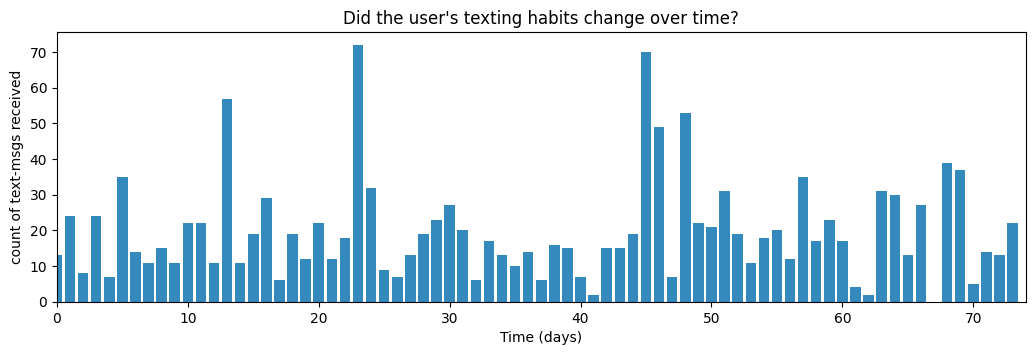

In [4]:
# plot of input data
figsize(12.5, 3.5)
# count_data = np.loadtxt("txtdata.csv")
count_data = df[0].values
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [5]:
# definition parameters of prior
# tau:switchpoint day
# lambda_1:before switch day
# lambda_2:ater switch day
 
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [6]:
# lambda_1,lambda_2 to lambda_
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
 
# Model
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [7]:
# sampling
# return_inferencedata=True

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
# # sampling
# # return_inferencedata=True

# with model:
#     start = pm.find_MAP()
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(2000, tune=2000, cores=4, return_inferencedata=True)
#     posterior_predictive = pm.sample_posterior_predictive(trace)

In [9]:
# trace

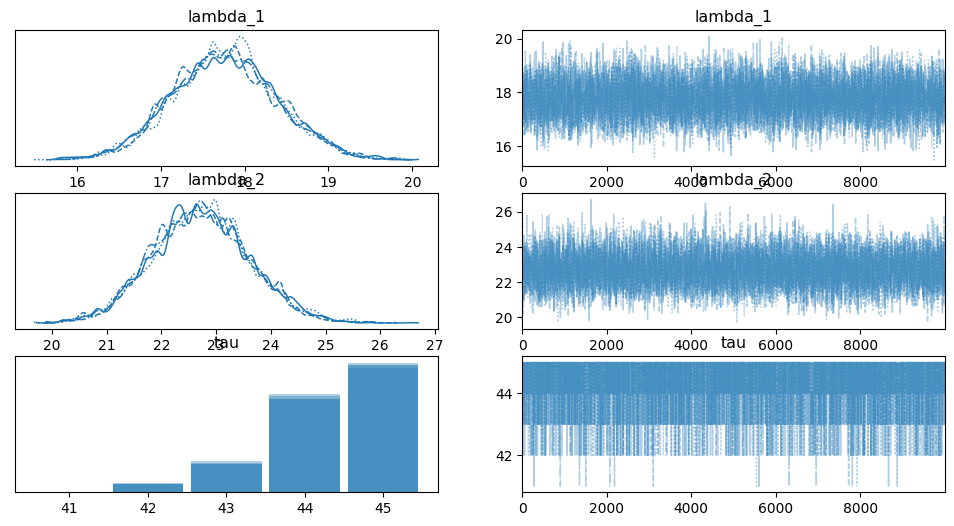

In [10]:
# analyze sampling results
# trace_plot
# az.plot_trace(trace);
az.plot_trace(trace, var_names=["lambda_1", "lambda_2", "tau"]);

In [11]:
# summary_plot
# az.summary(trace, hdi_prob=0.95)
az.summary(trace, hdi_prob=0.8)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,44.305,0.804,44.000,45.000,0.011,0.008,5420.0,6102.0,1.0
lambda_1,17.769,0.627,16.955,18.562,0.007,0.005,7662.0,7648.0,1.0
lambda_2,22.722,0.888,21.586,23.860,0.010,0.007,7571.0,8634.0,1.0


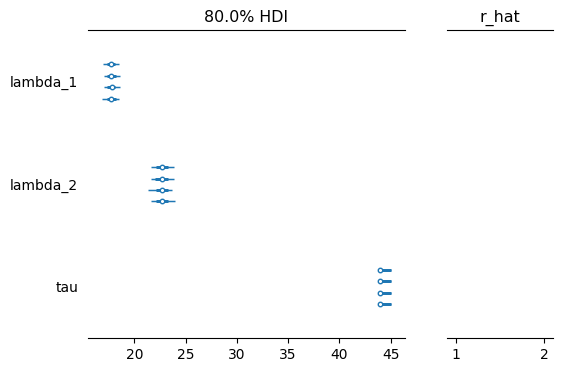

In [12]:
# foresplot

az.plot_forest(trace, r_hat=True, hdi_prob=0.8, figsize=(6,4), textsize=10,
              var_names=["lambda_1", "lambda_2", "tau"]);

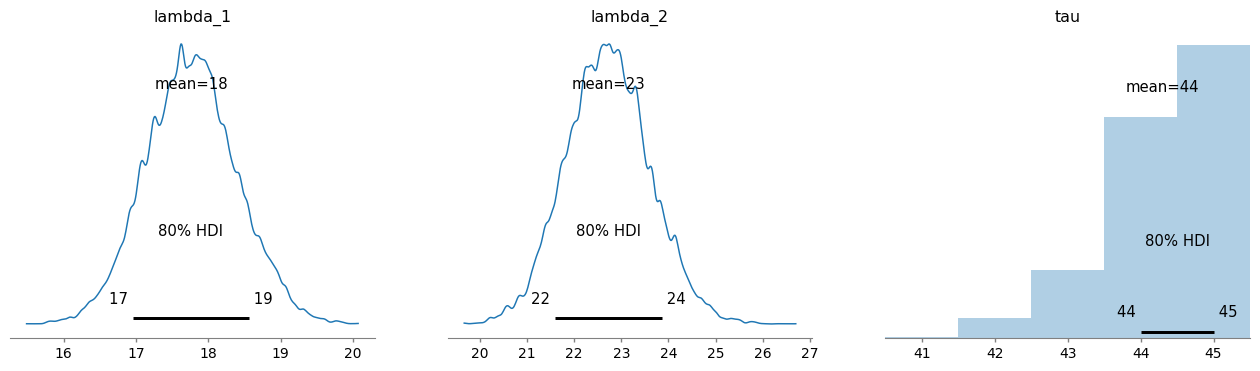

In [13]:
# posterior_samples_with_summary
# az.plot_posterior(trace, hdi_prob=0.8);
az.plot_posterior(trace, hdi_prob=0.8, figsize=(16,4), textsize=10,
                  var_names=["lambda_1", "lambda_2", "tau"]);

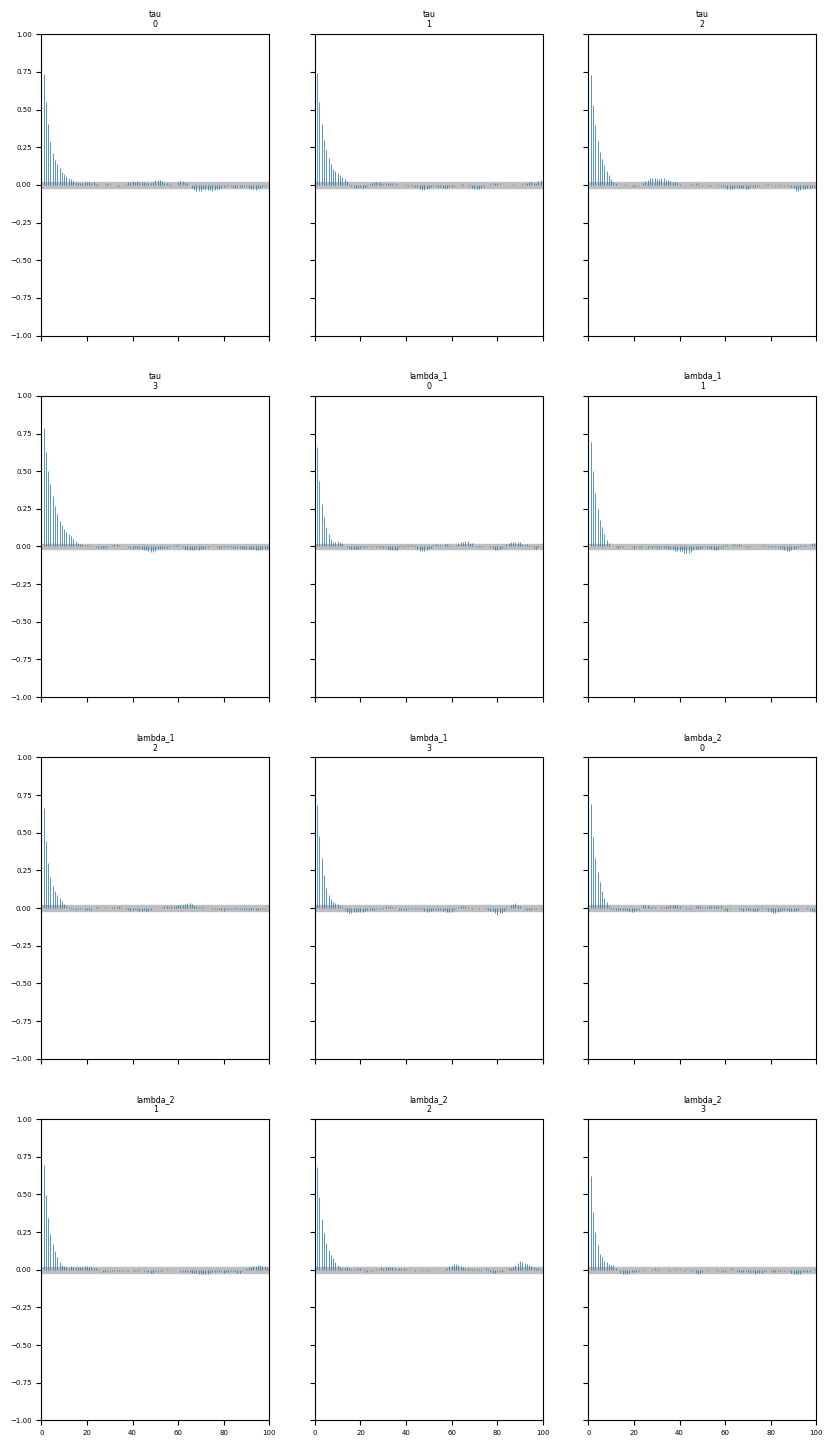

In [14]:
az.plot_autocorr(trace, figsize=(10,18), textsize=5);

In [15]:
# パラメーターの事後分布のdatasetを読み込む
# 多次元配列を一次元にする
lambda_1_samples = np.array(trace.posterior['lambda_1']).reshape(-1,)
lambda_2_samples = np.array(trace.posterior['lambda_2']).reshape(-1,)
tau_samples = np.array(trace.posterior['tau']).reshape(-1,)

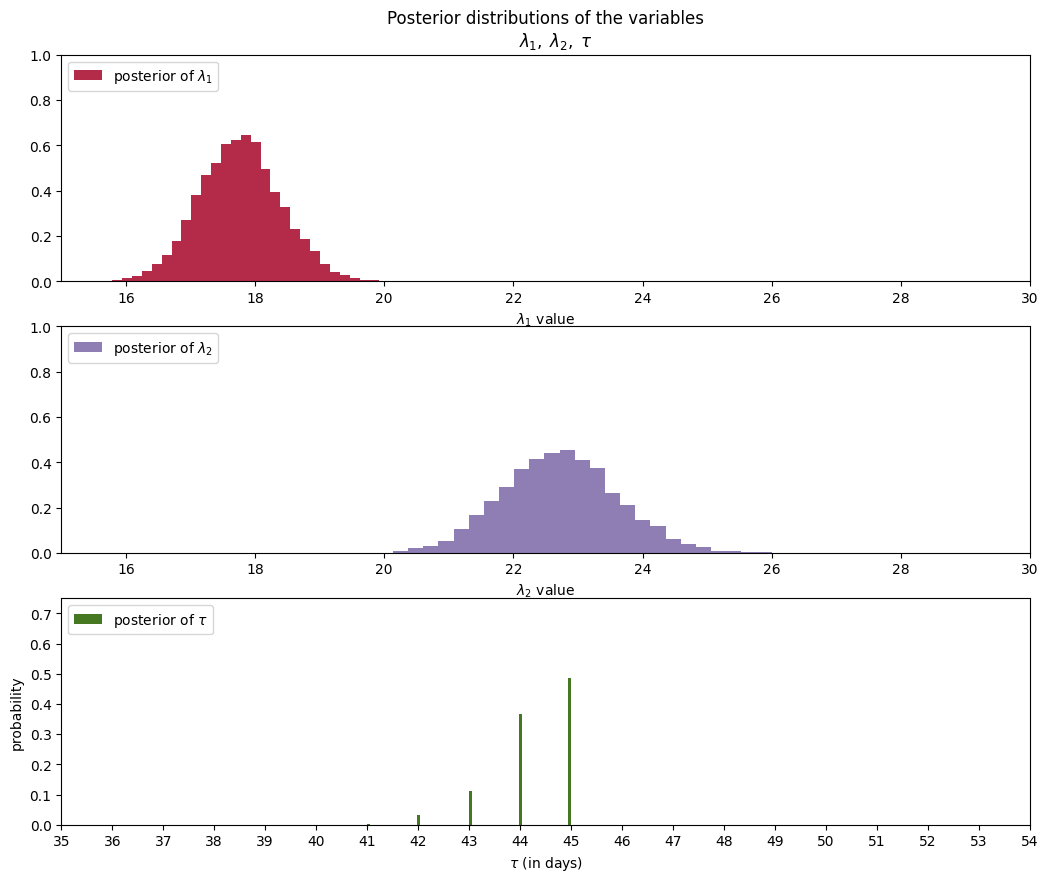

In [16]:
#histgram of the samples:
figsize(12.5, 10)
 
ax = plt.subplot(311)
ax.set_autoscaley_on(False)
 
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
 
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
 
plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
# w = 1.0 / len(tau_samples) * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
 
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

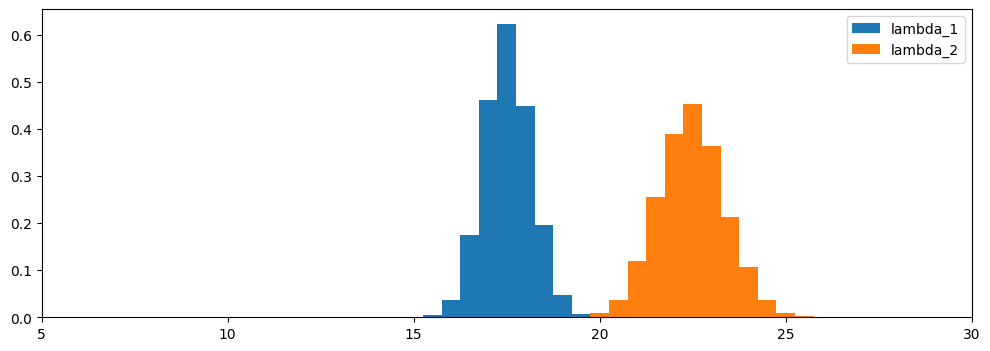

In [17]:
# histgram of lambda_1,lambda_2
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(lambda_1_samples, density=True, bins=np.arange(0, n_count_data, 0.5), align='left', label='lambda_1')
ax.hist(lambda_2_samples, density=True, bins=np.arange(0, n_count_data, 0.5), align='left', label='lambda_2')
 
# ax.set_xlim(30, 5, 1)
ax.set_xlim(5, 30)
plt.legend()
plt.show()

In [18]:
# the probability of lambda_2 is greater than lambda_1

print('lambda1 < lambda_2 : ', np.sum(lambda_1_samples < lambda_2_samples) / lambda_1_samples.shape[0])
# print('lambda1 < lambda_2 : ', (lambda_1_samples < lambda_2_samples).mean())

lambda1 < lambda_2 :  1.0


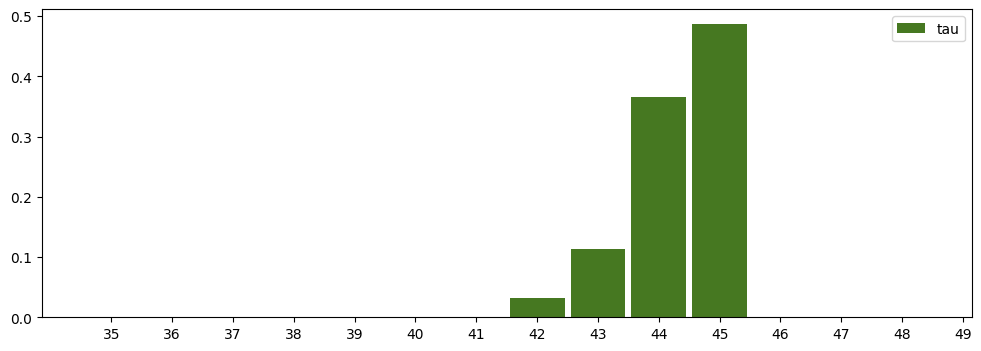

In [19]:
# histgram of tau
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(tau_samples, density=True, rwidth=0.9, 
        bins=np.arange(35, 50, 1), align='left', label='tau', color="#467821")
 
ax.set_xticks(np.arange(35, 50, 1))
plt.legend()
plt.show()

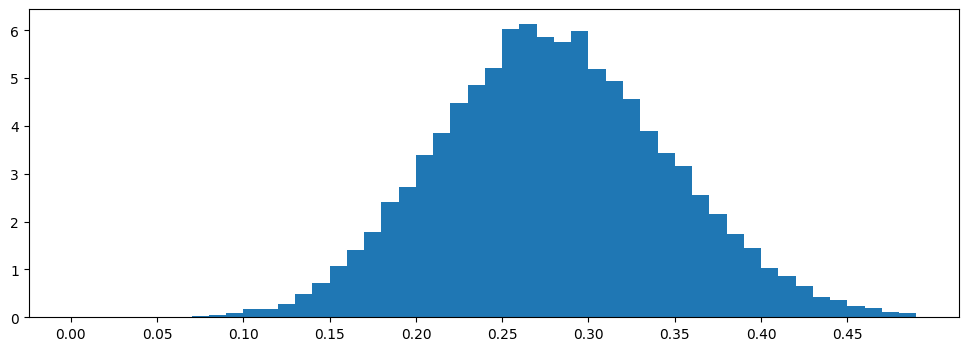

In [20]:
# the posterior of ditribution of the relative increase
relative_increase_samples = (lambda_2_samples - lambda_1_samples) / lambda_1_samples
 
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(relative_increase_samples, bins=np.arange(0, 0.5, 0.01), density=True)
ax.set_xticks(np.arange(0, 0.5, 0.05))
plt.show()

In [21]:
# mean of probability of increasing messages
print('mean of relative increase : {:.2f}%'.format(relative_increase_samples.mean() * 100))

mean of relative increase : 28.04%


In [22]:
# extra
# bool array： if lambda_1 is less than lambda_2, True
print(lambda_1_samples < lambda_2_samples)
 
# count samples lambda_1 is less than lambda_2
print((lambda_1_samples < lambda_2_samples).sum())
 
# count all samples
print(lambda_1_samples.shape[0])
 
# the probability of two parameters are different
print((lambda_1_samples < lambda_2_samples).mean())


[ True  True  True ...  True  True  True]
40000
40000
1.0


In [23]:
# definition parameters of prior
# tau:switchpoint day
# lambda_1:before switch day
# lambda_2:ater switch day
 
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [24]:
# lambda_1,lambda_2 to lambda_
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
 
# Model
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [25]:
# return_inferencedata=False

with model:
    start = pm.find_MAP()
    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=2000, initvals=start, cores=4, return_inferencedata=False)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    pm_data = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
    )
# pm_data

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
# pm_data

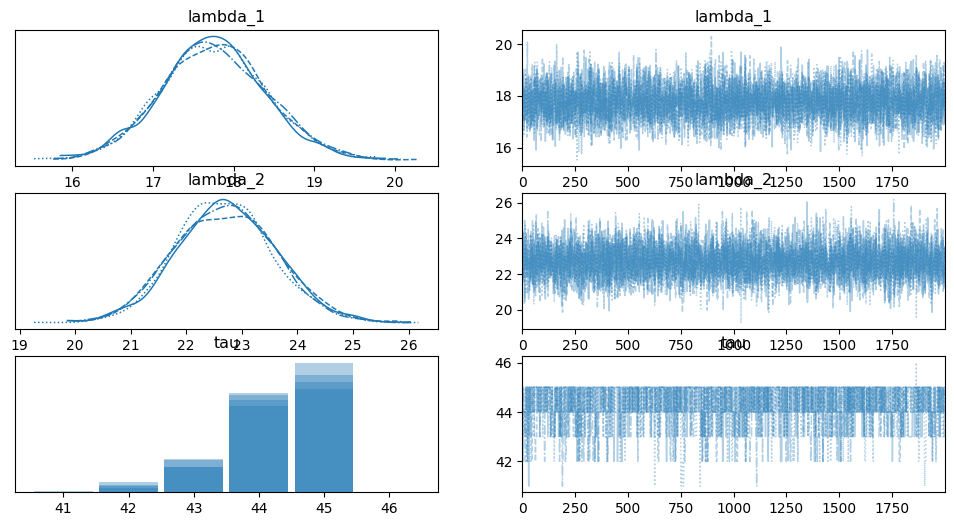

In [27]:
# analyze sampling results
# trace_plot
# az.plot_trace(pm_data);
az.plot_trace(pm_data, var_names=["lambda_1", "lambda_2", "tau"]);

In [28]:
# summary_plot
# az.summary(pm_data, hdi_prob=0.95)
az.summary(pm_data, hdi_prob=0.8)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,44.284,0.802,44.000,45.000,0.023,0.017,1186.0,1382.0,1.01
lambda_1,17.754,0.646,16.892,18.544,0.008,0.006,6431.0,5446.0,1.00
lambda_2,22.707,0.900,21.486,23.760,0.011,0.008,7082.0,5915.0,1.00


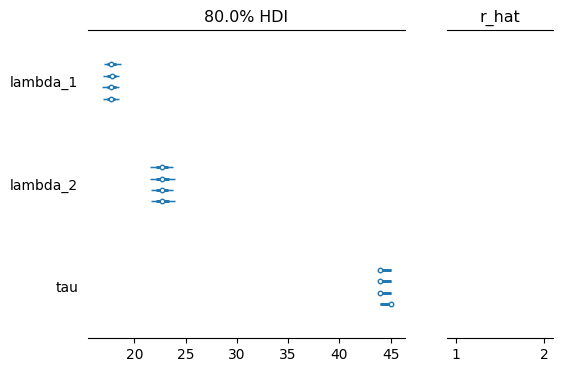

In [29]:
# foresplot
az.plot_forest(pm_data, r_hat=True, hdi_prob=0.8, figsize=(6,4), textsize=10,
              var_names=["lambda_1", "lambda_2", "tau"]);

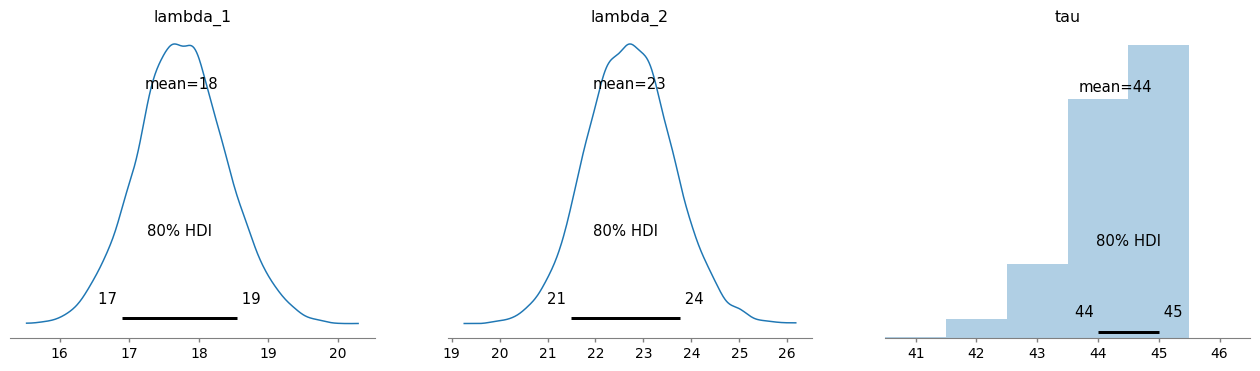

In [30]:
# posterior_samples_with_summary
# az.plot_posterior(pm_data, hdi_prob=0.8);
az.plot_posterior(pm_data, hdi_prob=0.8, figsize=(16,4), textsize=10,
                  var_names=["lambda_1", "lambda_2", "tau"]);

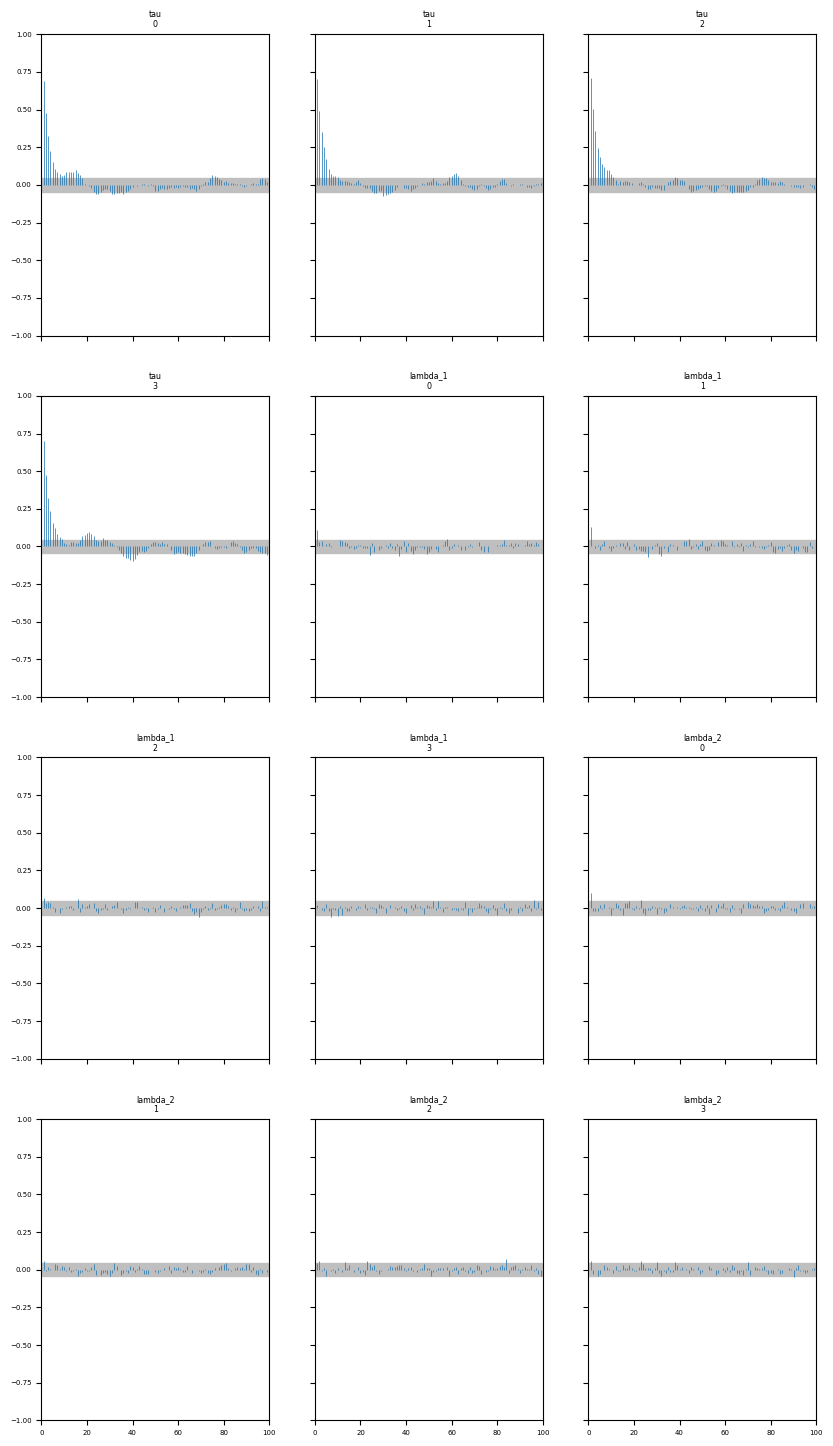

In [31]:
az.plot_autocorr(pm_data, figsize=(10,18), textsize=5);

In [32]:
# パラメーターの事後分布のdatasetを読み込む
# 多次元配列を一次元にする
lambda_1_samples = np.array(pm_data.posterior['lambda_1']).reshape(-1,)
lambda_2_samples = np.array(pm_data.posterior['lambda_2']).reshape(-1,)
tau_samples = np.array(pm_data.posterior['tau']).reshape(-1,)

# import itertools
# # パラメーターの事後分布のdatasetを読み込んで、平坦化して、リストで読み込む
# lambda_1_samples = list(itertools.chain.from_iterable(pm_data.posterior["lambda_1"]))
# lambda_2_samples = list(itertools.chain.from_iterable(pm_data.posterior["lambda_2"]))
# tau_samples = list(itertools.chain.from_iterable(pm_data.posterior["tau"]))

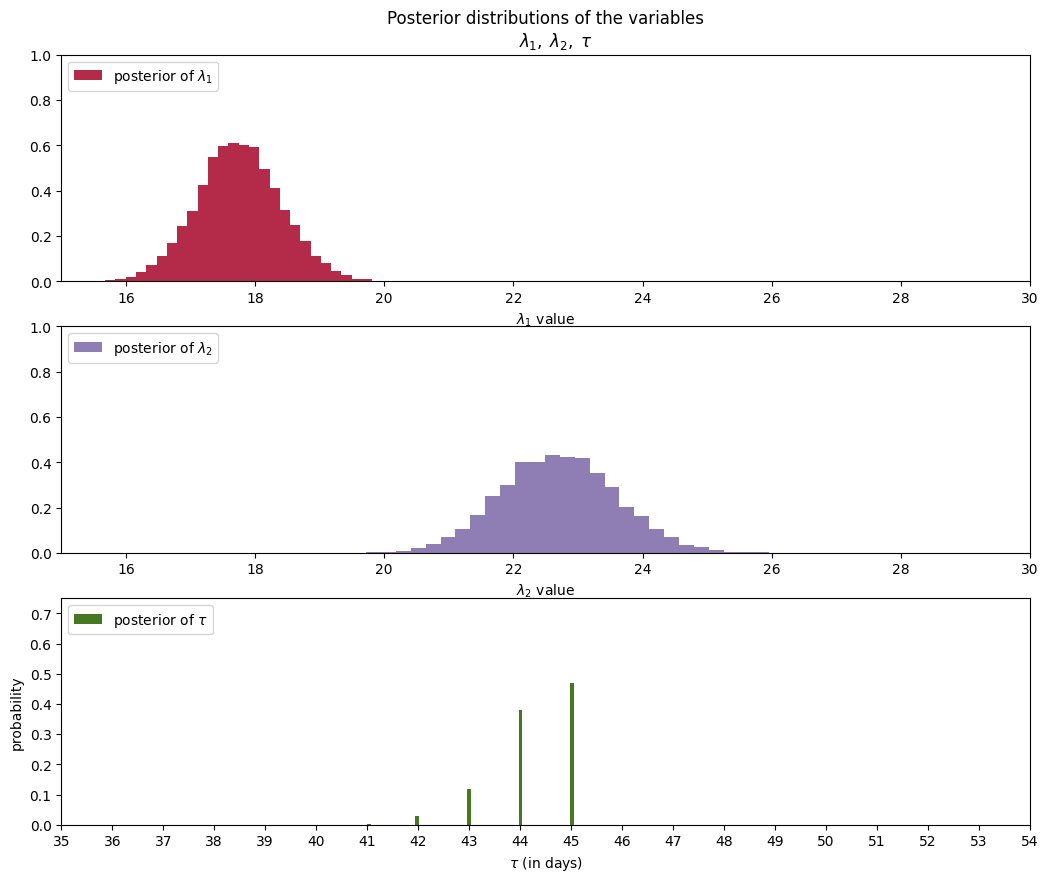

In [33]:
#histgram of the samples:
figsize(12.5, 10)
 
ax = plt.subplot(311)
ax.set_autoscaley_on(False)
 
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
 
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
 
plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
# w = 1.0 / len(tau_samples) * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
 
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

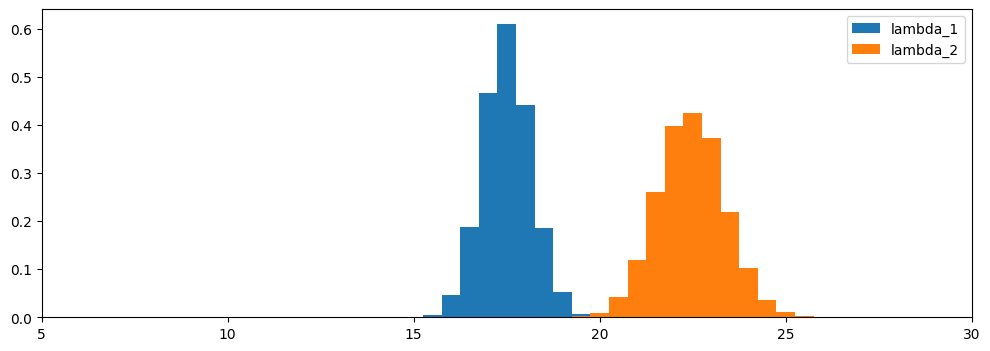

In [34]:
# histgram of lambda_1,lambda_2
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(lambda_1_samples, density=True, bins=np.arange(0, n_count_data, 0.5), align='left', label='lambda_1')
ax.hist(lambda_2_samples, density=True, bins=np.arange(0, n_count_data, 0.5), align='left', label='lambda_2')
 
# ax.set_xlim(30, 5, 1)
ax.set_xlim(5, 30)
plt.legend()
plt.show()

In [35]:
# the probability of lambda_2 is greater than lambda_1

print('lambda1 < lambda_2 : ', np.sum(lambda_1_samples < lambda_2_samples) / lambda_1_samples.shape[0])
# print('lambda1 < lambda_2 : ', (lambda_1_samples < lambda_2_samples).mean())

lambda1 < lambda_2 :  1.0


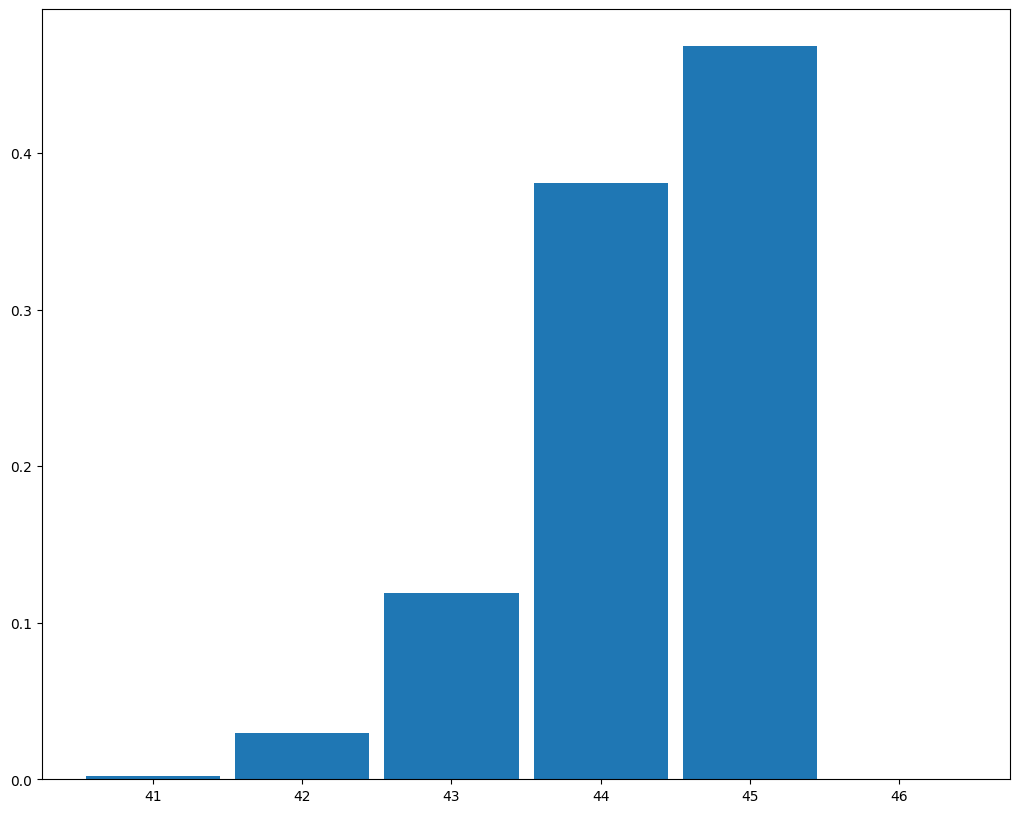

In [36]:
az.plot_dist(tau_samples);

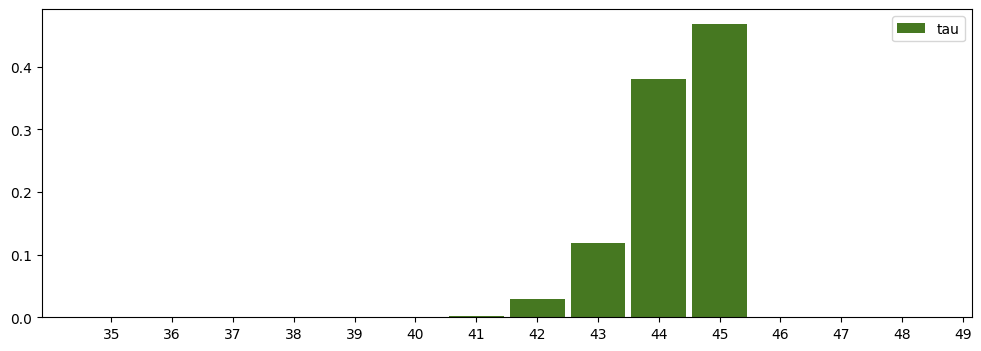

In [37]:
# histgram of tau
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(tau_samples, density=True, rwidth=0.9, 
        bins=np.arange(35, 50, 1), align='left', label='tau', color="#467821")
 
ax.set_xticks(np.arange(35, 50, 1))
plt.legend()
plt.show()

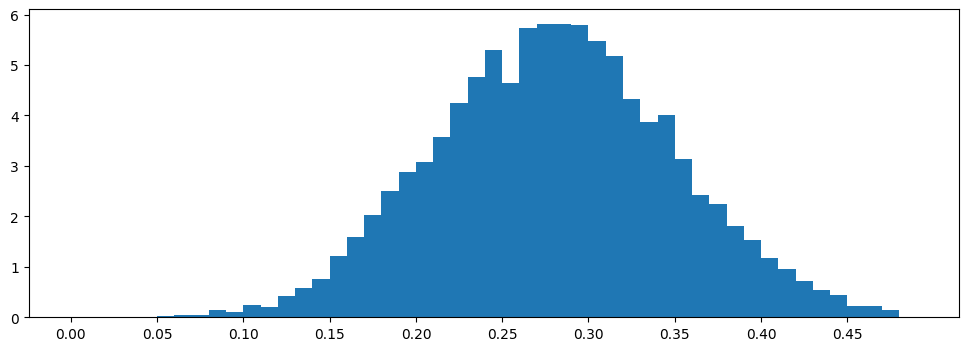

In [38]:
# the posterior of ditribution of the relative increase
relative_increase_samples = (lambda_2_samples - lambda_1_samples) / lambda_1_samples
 
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(relative_increase_samples, bins=np.arange(0, 0.5, 0.01), density=True)
ax.set_xticks(np.arange(0, 0.5, 0.05))
plt.show()

In [39]:
# mean of probability of increasing messages
print('mean of relative increase : {:.2f}%'.format(relative_increase_samples.mean() * 100))

mean of relative increase : 28.07%


In [40]:
# extra
# bool array： if lambda_1 is less than lambda_2, True
print(lambda_1_samples < lambda_2_samples)
 
# count samples lambda_1 is less than lambda_2
print((lambda_1_samples < lambda_2_samples).sum())
 
# count all samples
print(lambda_1_samples.shape[0])
 
# the probability of two parameters are different
print((lambda_1_samples < lambda_2_samples).mean())


[ True  True  True ...  True  True  True]
8000
8000
1.0
